In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import funcs as f
from itertools import combinations 

import vtreat
import vtreat.util

from os import path as op

import gc

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import minmax_scale
import category_encoders as ce
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, accuracy_score, precision_score, recall_score


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, BaggingClassifier, VotingClassifier, RandomTreesEmbedding
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier, SGDClassifier, LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING

import xgboost as xgb
from xgboost import XGBClassifier
import xgbfir

import KTBoost.KTBoost as KTBoost

import warnings
warnings.filterwarnings("ignore")

rand_state = 42

In [221]:
data = pd.read_csv('student-data.csv')
#rename passed as target
data.rename(columns={"passed": "target"}, inplace = True)
#relabel target to find failing students no:1 yes :0
data['target'] = data['target'].map({'no':0, 'yes':1})


In [222]:
#organize and catgorize variables
nom_cols = 'Mjob Fjob reason guardian'.split()
bin_cols = 'school sex address famsize Pstatus schoolsup famsup paid activities nursery higher internet romantic'.split()
ord_cols = 'Medu Fedu traveltime studytime failures famrel freetime goout Dalc Walc health'.split()
other = 'age absences'.split()
used_cols = nom_cols+bin_cols+ord_cols+other
# for col in ord_cols:
#     print(data[col].value_counts())

# EDA

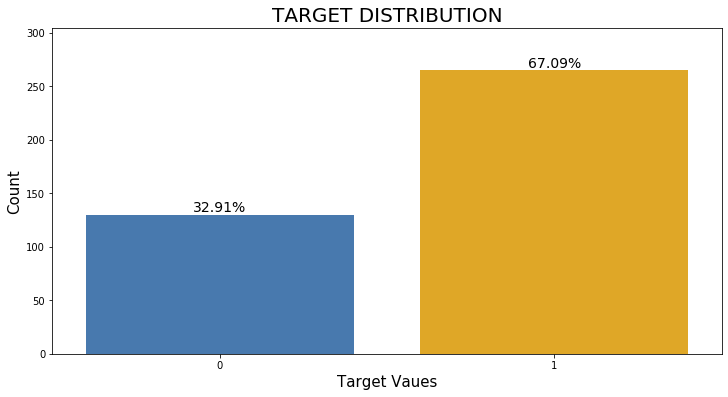

In [223]:
colors = ["windows blue", "amber"]
palette = sns.xkcd_palette(colors)
total = len(data)
plt.figure(figsize=(12,6))

g = sns.countplot(x='target', data=data, palette = palette)
g.set_title("TARGET DISTRIBUTION", fontsize = 20)
g.set_xlabel("Target Vaues", fontsize = 15)
g.set_ylabel("Count", fontsize = 15)
sizes=[] # Get highest values in y
for p in g.patches:
    height = p.get_height()
    sizes.append(height)
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 
g.set_ylim(0, max(sizes) * 1.15) # set y limit based on highest heights

plt.show()

## Target Observation:
* Target is students who have failed the course
* Target variable is imbalanced, many more students pass the course than do not
    * Although F1 Score seems applicable measure of accuracy it is not th best metric for the problem at hand
    * Bcause I want to minimize false positives I will prioriti that ROC_AUC score
    

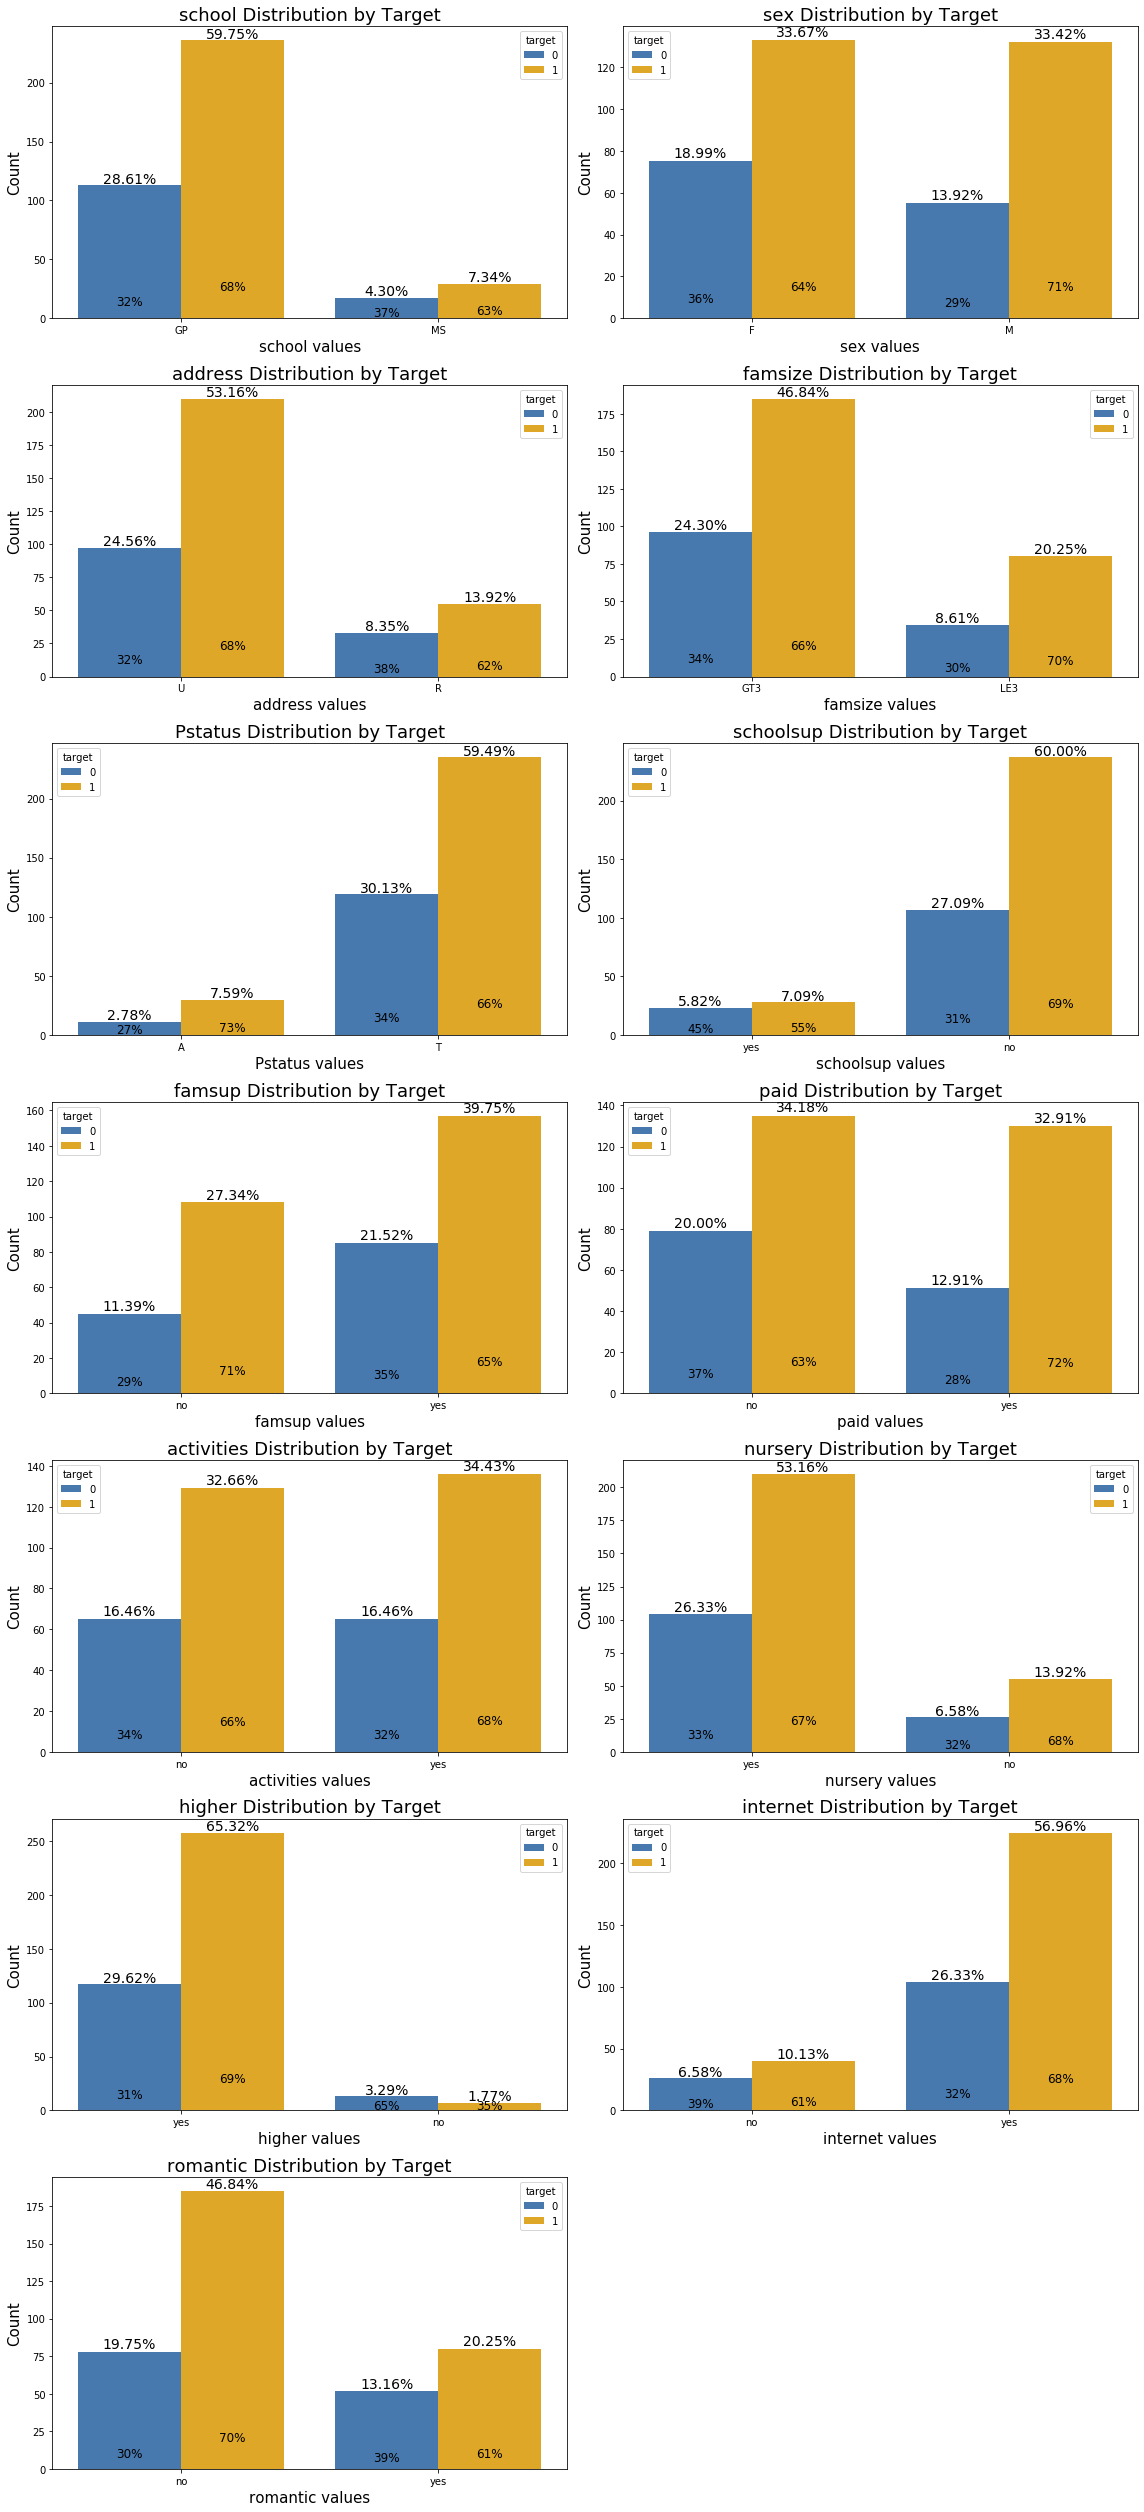

In [224]:
#Looking the V's features
 # to do the grid of plots
colors = ["windows blue", "amber"]
palette = sns.xkcd_palette(colors)
grid = gridspec.GridSpec(7, 2) # The grid of chart
plt.figure(figsize=(16,35)) # size of figure
total = len(data)
# loop to get column and the count of plots
for n, col in enumerate(data[bin_cols]): 
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    sns.countplot(x=col, data=data, hue='target',  palette = palette) 
    ax.set_ylabel('Count', fontsize=15) # y axis label
    ax.set_title(f'{col} Distribution by Target', fontsize=18) # title label
    ax.set_xlabel(f'{col} values', fontsize=15) # x axis label
    sizes=[] # Get highest values in y
    
    bars = ax.patches
    half = int(len(bars)/2)
    left_bars = bars[:half]
    right_bars = bars[half:]

    for left, right in zip(left_bars, right_bars):
        height_l = left.get_height()
        height_r = right.get_height()
        total1 = height_l + height_r

        ax.text(left.get_x() + left.get_width()/2., height_l *.10, '{0:.0%}'.format(height_l/total1), ha="center", fontsize=12)
        ax.text(right.get_x() + right.get_width()/2., height_r * .10, '{0:.0%}'.format(height_r/total1), ha="center", fontsize=12)

        
    for p in ax.patches: # loop to all objects
        height = p.get_height()
        sizes.append(height)
        ax.text(p.get_x()+p.get_width()/2.,
                height + 2,
                '{:1.2f}%'.format(height/total*100),
                ha="center", fontsize=14) 

plt.tight_layout() 
plt.show()

## Binary Observations:
* Spcifically looking for balanced binary data has greater % occurance of our target
* Within 5%:
    * nursery - 1 - yes
    * activities - 2 - no
    * famsize - 4 - GT3
    * School - 5 - MS
* Within 10%
    * famsup - 6 - yes
    * address - 6 - R
    * sex - 7 - T
    * internet - 7 - no
    * Pstatus - 7 - T
    * romantic - 9 - yes 
    * paid - 9 - no
* Above 10%
    * schoolsup - 14 - yes
    * higher - 34 - no

From the binary variables, it easy to see one of the variables that will be giving us a lot of predictive value is `higher` which is the desire to persue higher education. A second variables that will be insighful is `schoolsup` this can be treated as a sort of soft label as these are most likely students that haven been identified as at risk of failing.



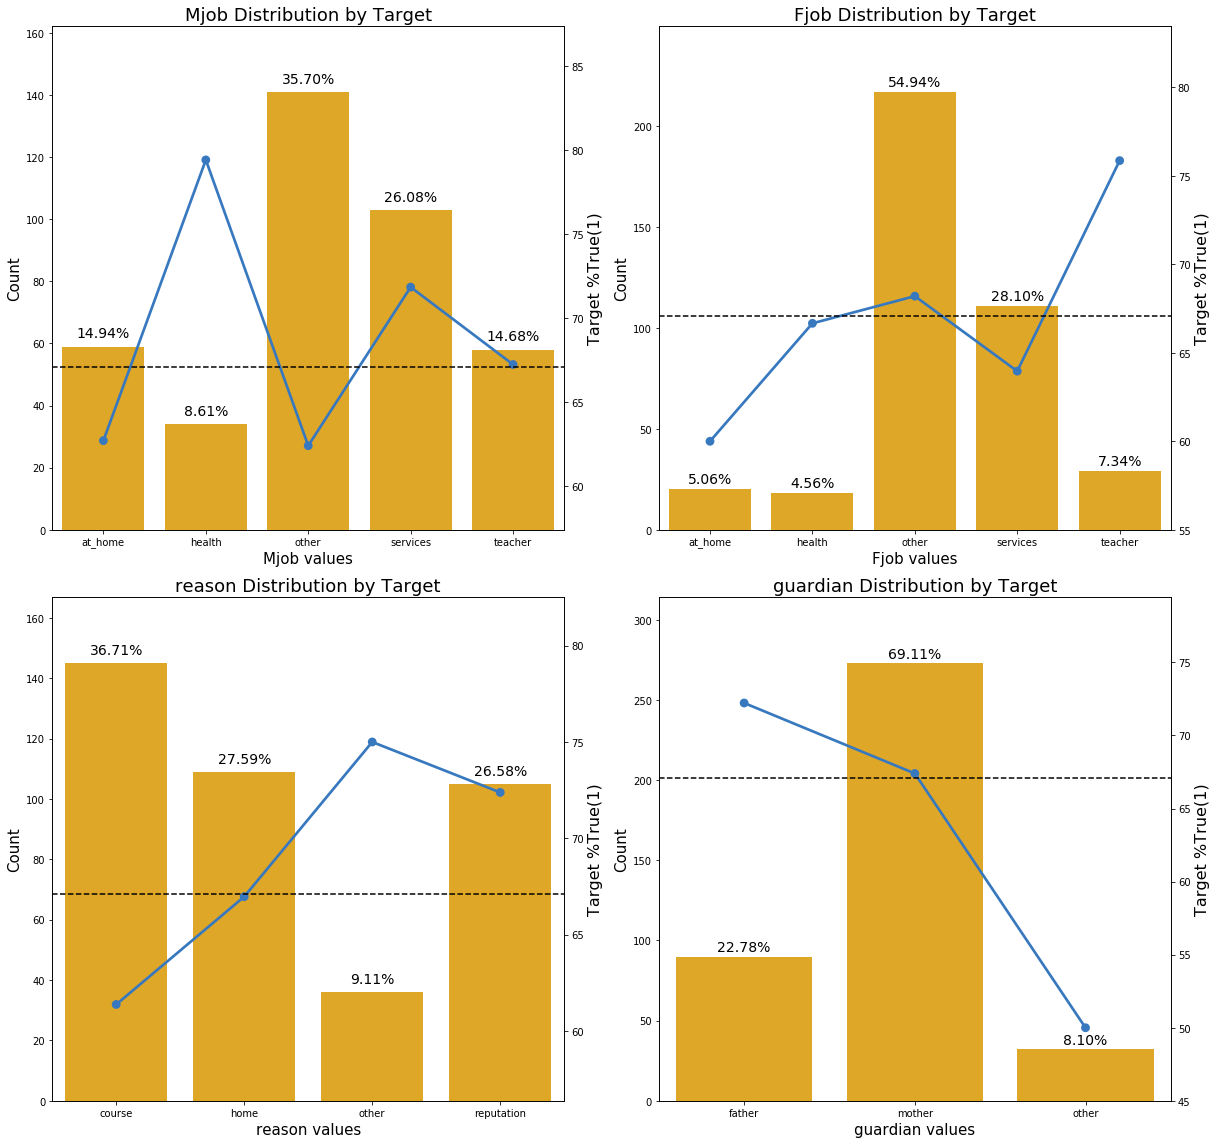

In [226]:
f.ploting_cat_fet(data, nom_cols, vis_row=2, vis_col=2)

## Nominal Observations:
Variables that have categories that have about 32% target are of value
* Mjob
    * At home, Services, and Other are above 30% for target variable
* Fjob
    * At Home has the highest % of target but almost the lowest counts in this category
    * Health, Other, and Services are all about 30%
* reason
    * Course has the highes about 37.5% of target and Home has second highest about equal to target % in data
* guardian
    * Other has the highest percentage of our target variable at 50% but has the lowest count of this category
    * Mother has above 30% of target 


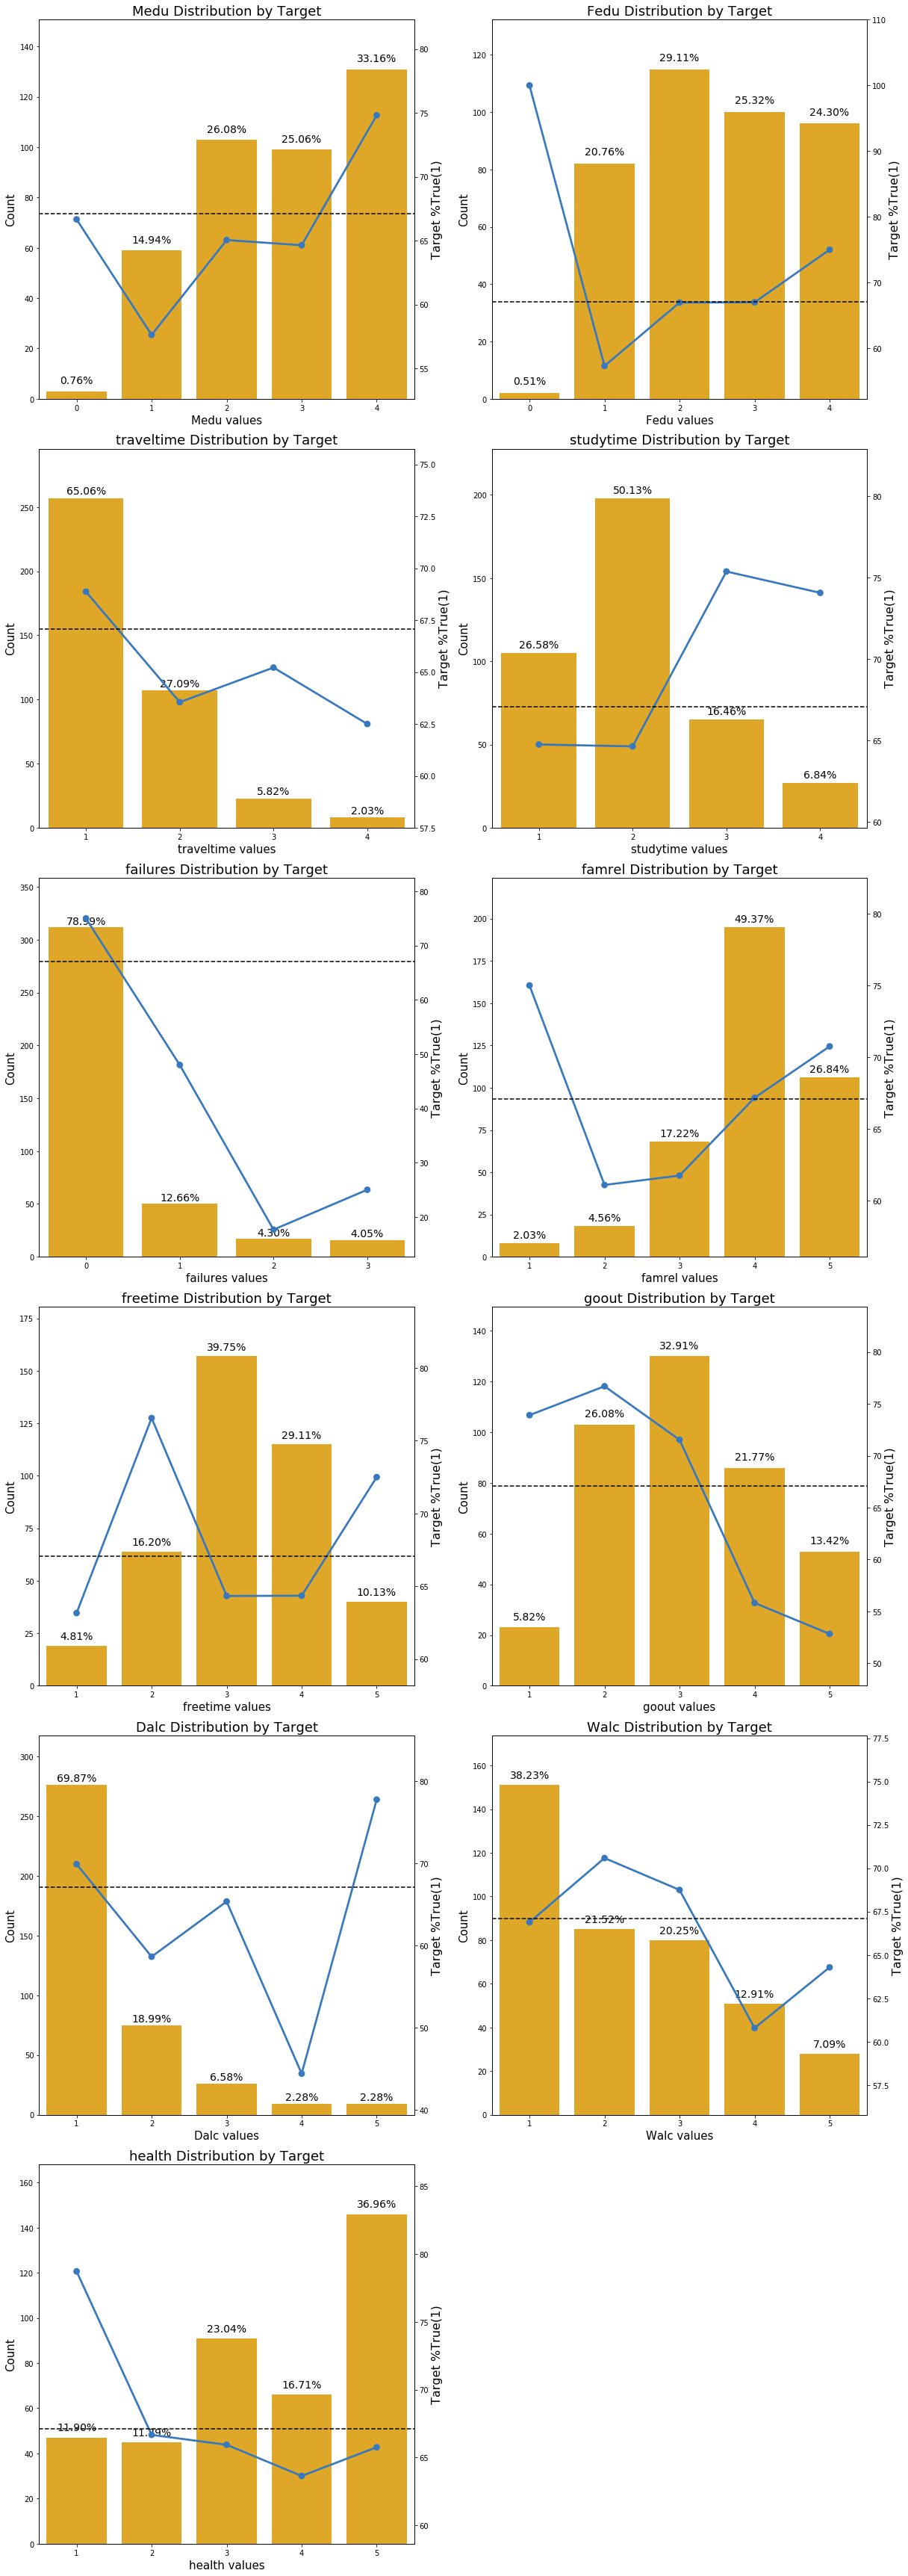

In [228]:
f.ploting_cat_fet(data, ord_cols, vis_row=6, vis_col=2)

## Ordinal Observations
* `Mjob` - Mothers job
    * 0-1 3 have the highst target percentages
    * 1 > 40% of target
* `Fjob` - Fathers job
    * Doesn't seem to be as important as Mothers job
    * 1 has highst target% above data at 40%
* `traveltime` - home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
    * anything above 1(15 min) seems to have an effect
    * 2 & 4 hav the highst at about 38%
* `studytime` - weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
    * seems to be more categories than needd
    * 1 & 2 hav the most target % at 35% 
* `failures` - number of past class failures (numeric: n if 1<=n<3, else 4)
    * Huge Impact
    * 1- 50%, 2 - 80%, 3 - 75%
* `goout` - going out with friends (numeric: from 1 - very low to 5 - very high)
    * follows typical ordinal pattern
    * 4 - 44%, 5- 47%
* `famrel` - quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
    * doesn't follow ordinal pattern, doesn't make too much sense
    * 2 & 3 about 38%
* `freetime` - free time after school (numeric: from 1 - very low to 5 - very high)
    * also doesn't follow ordinal pattern, suspect that interaction betwen `freetime` and other time varaibles will be more telling of the whole story
    * 1 - 37.5%, 3/4 - 36%
* `Dalc`- workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
    * Does not follow ordinal patter
    * highest for lowerst count 
    * 4 - 55%, 3 - 35%, 2 - 40%
* `Wacl`- weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
    * 1 & 5 just above target
    * 4 - 40%
* `health` - current health status (numeric: from 1 - very bad to 5 - very good)
    * Doesn't make sense, as health increases the likihood that you fail the course also increases 
    * 2,3,5 jsut above target %
    * 4 above 35%
    


## Interaction among ordinal varaibales 

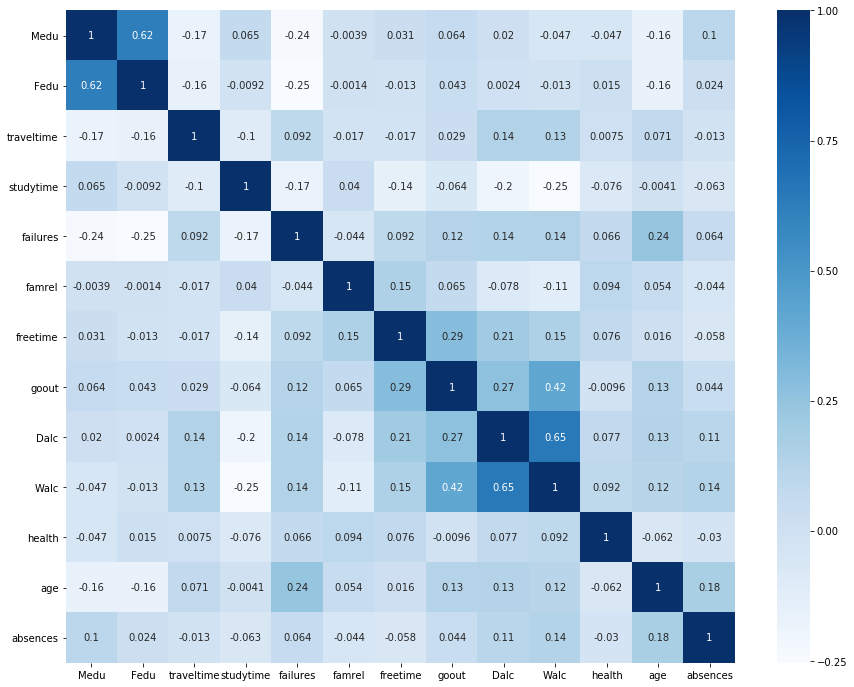

In [229]:
fig, ax = plt.subplots(figsize=(15,12)) 
ax = sns.heatmap(data[used_cols].corr(), annot = True, cmap = 'Blues')

### Heatmap Observations

* `Mdu` and `Fedu` hav some multicolinearirty and `Dalc` and `Wacl` have some multicolinearity 
* `goout` and `Walc` also hav a slight relationship


## What's Going on With `freetime`

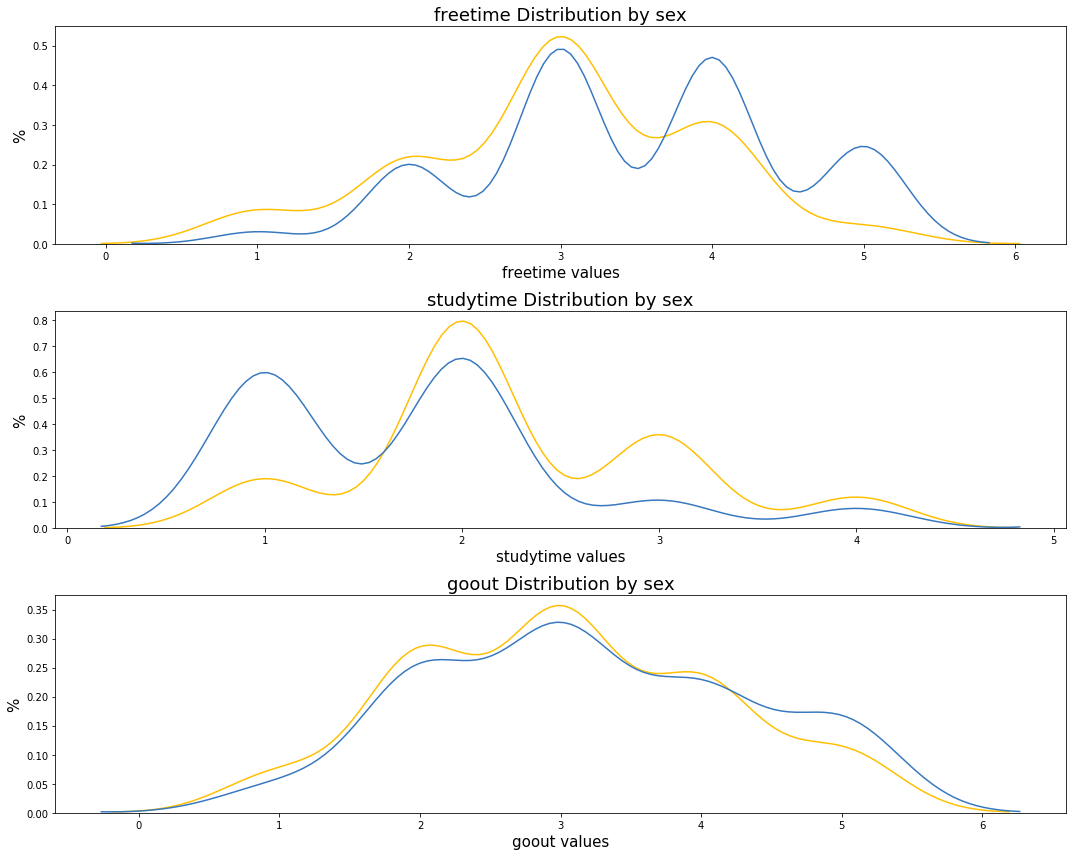

In [230]:
target_F = data.loc[data['sex']=='F']
target_M = data.loc[data['sex']=='M']

grid = gridspec.GridSpec(3,1) # The grid of chart
plt.figure(figsize=(15,12))

for n, col in enumerate(['freetime','studytime','goout']): 
    ax = plt.subplot(grid[n])
    sns.distplot(target_F[[col]], norm_hist = True, hist = False, color = '#ffbf00', kde=True)#yellow
    sns.distplot(target_M[[col]], norm_hist = True, hist = False, color = '#3778bf', kde=True)#blue
    ax.set_ylabel('%', fontsize=15) # y axis label
    ax.set_title(f'{col} Distribution by sex', fontsize=18) # title label
    ax.set_xlabel(f'{col} values', fontsize=15) # x axis label
    plt.tight_layout()

### Observations:
#### `sex` vs `freetime` `studytime` `goout`
* A greater percent of men self reported having more free time than female students in the course
* A greater % of males in the course also self reported spending less time studying 
* Males and Females in the course seem to report going out relatively the same

### Lets Engineer some features that connect `freetime` to `studytime` and `goout`

In [231]:
data['ratio_st_ft'] = data['studytime'] / data['freetime']
data['ratio_go_ft'] = data['goout'] / data['freetime']

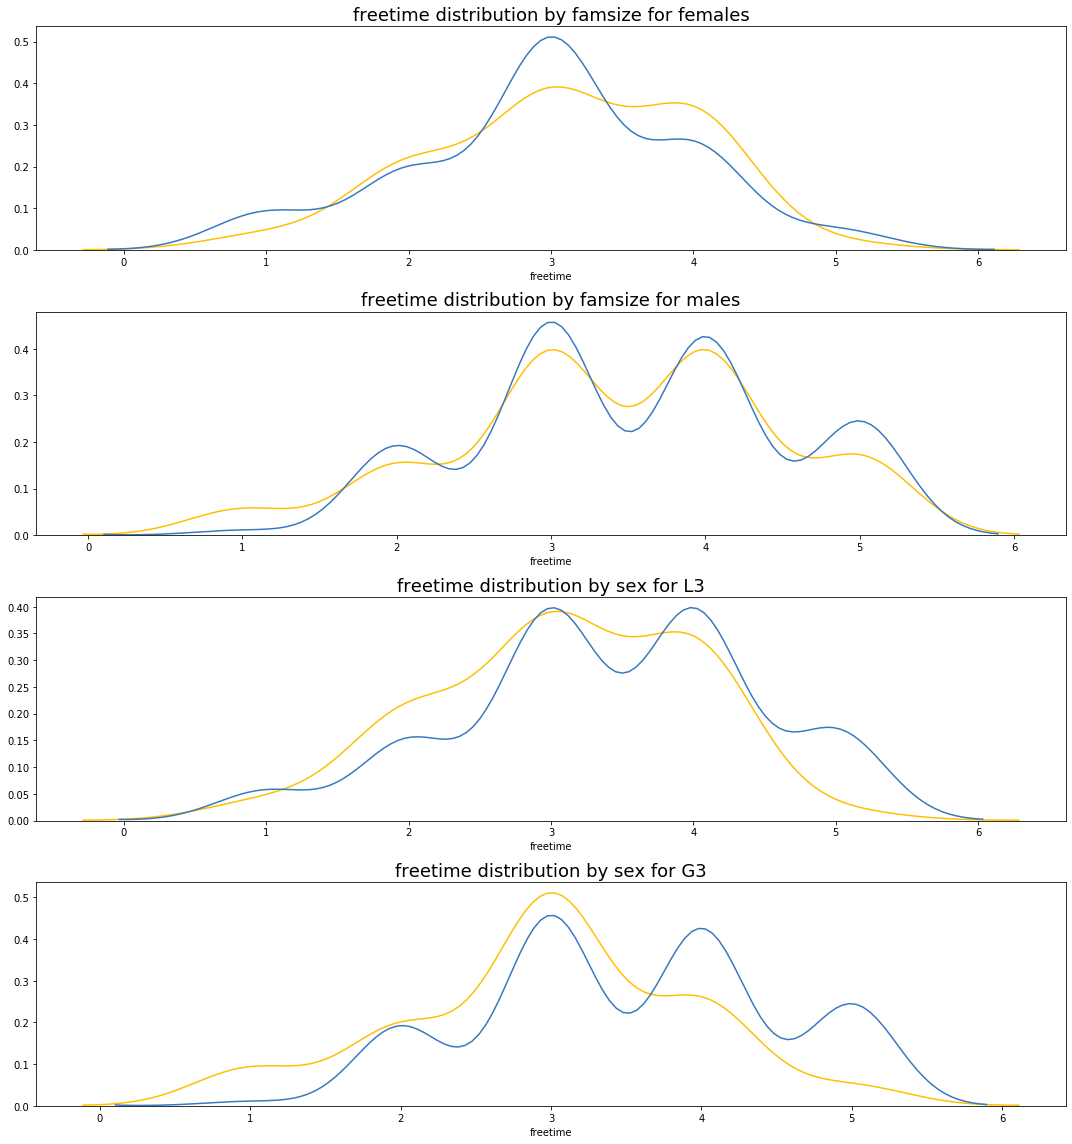

In [232]:
#Further Investigation: Does family size change the amount of free time females report having 
target_F = data.loc[data['sex']=='F']
target_M = data.loc[data['sex']=='M']
target_F_L3 = target_F.loc[target_F['famsize']=='LE3']
target_F_G3 = target_F.loc[target_F['famsize']=='GT3']
target_M_L3 = target_M.loc[target_M['famsize']=='LE3']
target_M_G3 = target_M.loc[target_M['famsize']=='GT3']

grid = gridspec.GridSpec(4,1) # The grid of chart
plt.figure(figsize=(15,16))
titles = ["freetime distribution by famsize for females", "freetime distribution by famsize for males", "freetime distribution by sex for L3", "freetime distribution by sex for G3"]
for n, tup in enumerate([(target_F_L3, target_F_G3), (target_M_L3, target_M_G3),(target_F_L3, target_M_L3), (target_F_G3, target_M_G3)]):
    ax = plt.subplot(grid[n])
    sns.distplot(tup[0]['freetime'], norm_hist = True, hist = False, color = '#ffbf00', kde=True)#yellow
    sns.distplot(tup[1]['freetime'], norm_hist = True, hist = False, color = '#3778bf', kde=True)#blue
    ax.set_title(titles[n], fontsize=18) # title label
    plt.tight_layout()




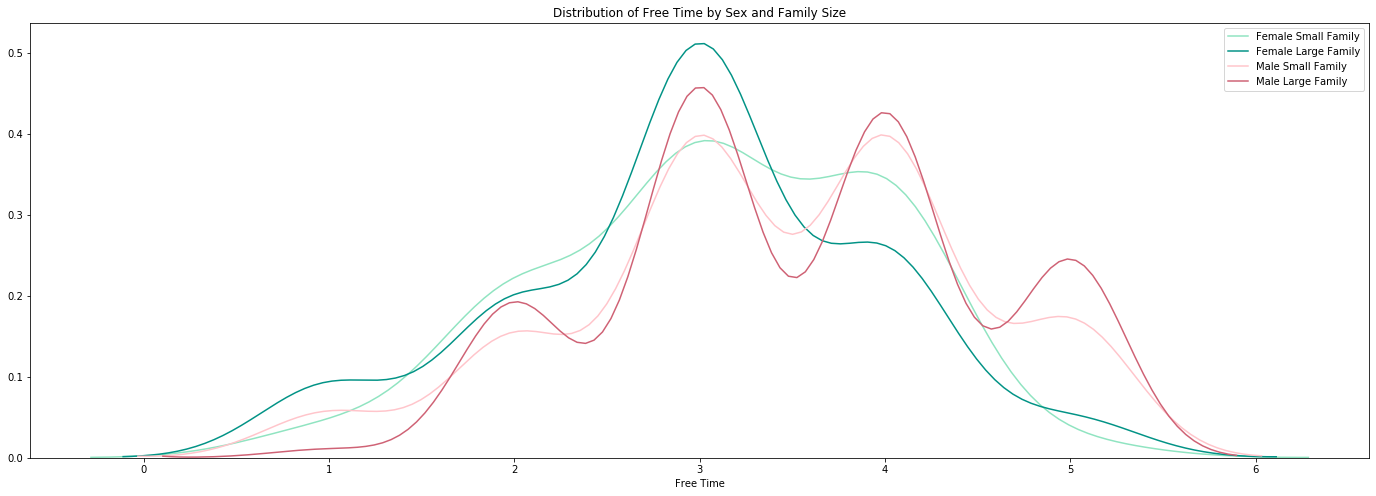

In [285]:
target_F = data.loc[data['sex']=='F']
target_M = data.loc[data['sex']=='M']
target_F_L3 = target_F.loc[target_F['famsize']=='LE3']
target_F_G3 = target_F.loc[target_F['famsize']=='GT3']
target_M_L3 = target_M.loc[target_M['famsize']=='LE3']
target_M_G3 = target_M.loc[target_M['famsize']=='GT3']
fig, ax = plt.subplots(figsize=(24,8))
sns.distplot(target_F_L3['freetime'], norm_hist = True, hist = False, color = '#90e4c1', kde=True, label = "Female Small Family").set_title('Distribution of Free Time by Sex and Family Size')#yellow
sns.distplot(target_F_G3['freetime'], norm_hist = True, hist = False, color = '#029386', kde=True, label = "Female Large Family")#yellow 
sns.distplot(target_M_L3['freetime'], norm_hist = True, hist = False, color = '#ffc5cb', kde=True, label = "Male Small Family")#blue
sns.distplot(target_M_G3['freetime'], norm_hist = True, hist = False, color = '#cf6275', kde=True,  label = "Male Large Family")#blue
plt.legend()
ax.set_xlabel('Free Time')
plt.show();


### Observations:
#### `sex`, `freetime`, and `famsize`
* Females from smaller families tend to have more free time
* `famsize` doesn't have an impact on mals free time
* Males from smaller families report more freetime than females
* Males from larger families report more freetime than females

## How are the support variabls related?

sch is 70.0 % target
fam is 58.333333333333336 % target
sch_paid is 66.66666666666666 % target
paid_fam is 74.16666666666667 % target
no_sup is 68.31683168316832 % target
sch_fam is 52.63157894736842 % target
paid is 76.92307692307693 % target
all is 47.368421052631575 % target


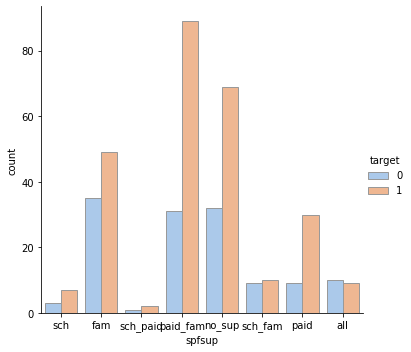

In [243]:
data['spfsup'] = list(zip(data['schoolsupE'], data['paidE'], data['famsupE']))
data['spfsup'] = data['spfsup'].map({(0,0,0): 'no_sup', (1,0,0): 'sch',(0,1,0): 'paid',(0,0,1): 'fam',
                                     (1,1,0):'sch_paid',(1,0,1):'sch_fam', (0,1,1):'paid_fam',
                                     (1,1,1): 'all'})
sns.catplot(x="spfsup", hue = 'target', kind="count",
            palette="pastel", edgecolor=".6",
            data=data);
for cat in data['spfsup'].unique():
    print(cat, "is", (data.loc[data['spfsup']==cat]['target'].sum()/(data.loc[data['spfsup']==cat]['target'].count()))*100, "% target")

In [244]:
data['spsup'] = list(zip(data['schoolsupE'], data['paidE']))


### Observation:
* The level of target in each support combination changes so it may be a good feature to include 
* It will be target encoded

## Lets Look at Absences & Age

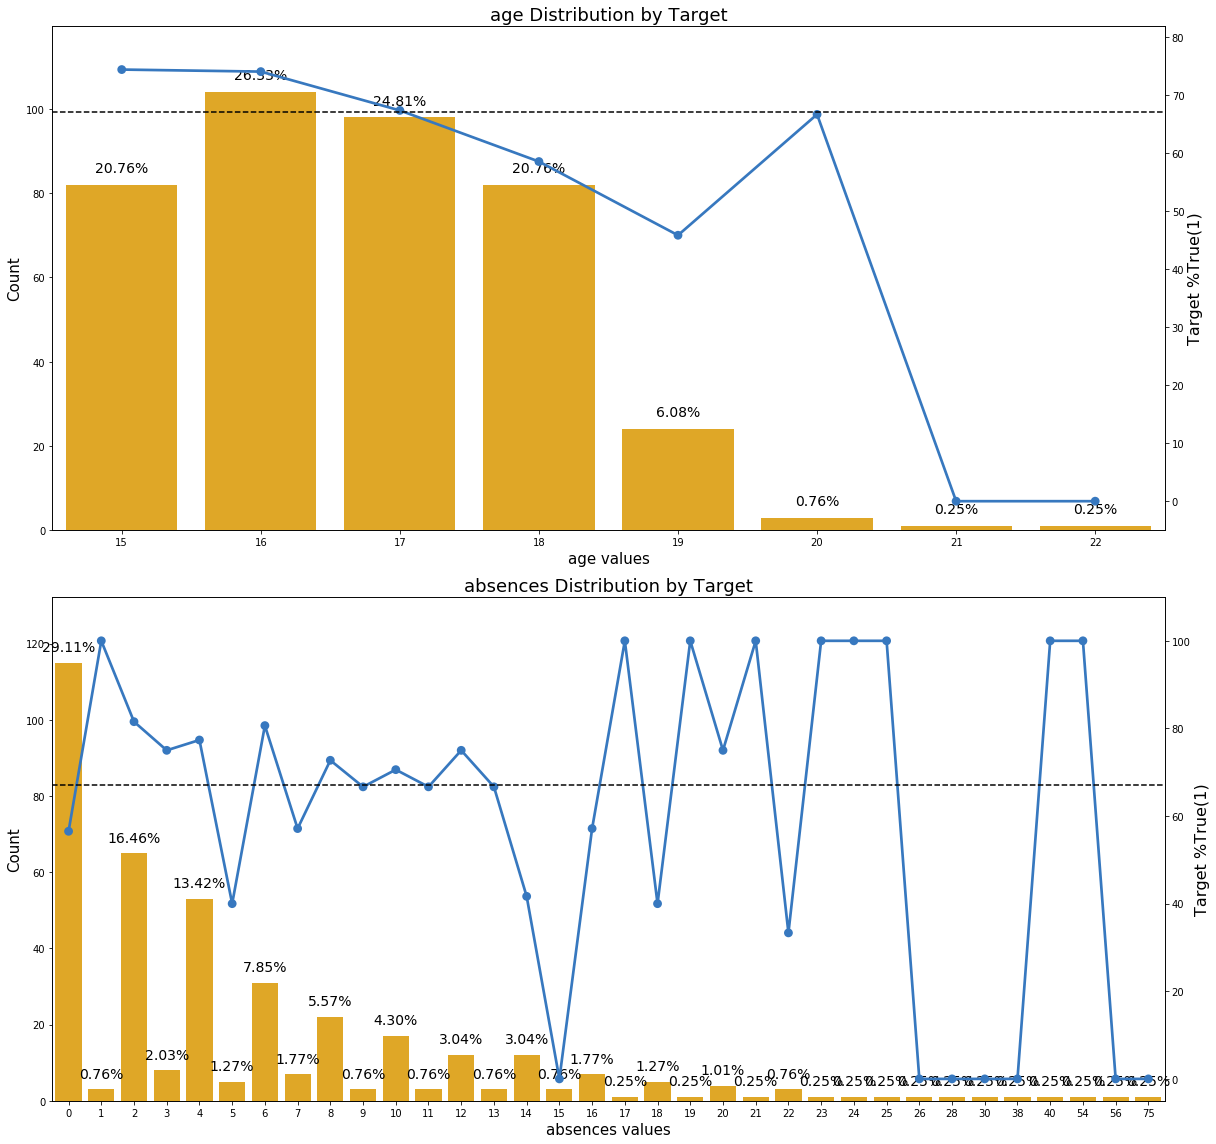

In [249]:
f.ploting_cat_fet(data, ['age', 'absences'], vis_row=2, vis_col=1)

### Observations
* There seems to be enough variability of %target across both age and absences to keep both var
* Absences is too much though so we will bin it - Will bin according to quartiles

In [250]:
data['absences'].describe()


count    395.000000
mean       5.708861
std        8.003096
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max       75.000000
Name: absences, dtype: float64

In [251]:
data['absences_binned'] = data['absences'].apply(f.abs_bin)

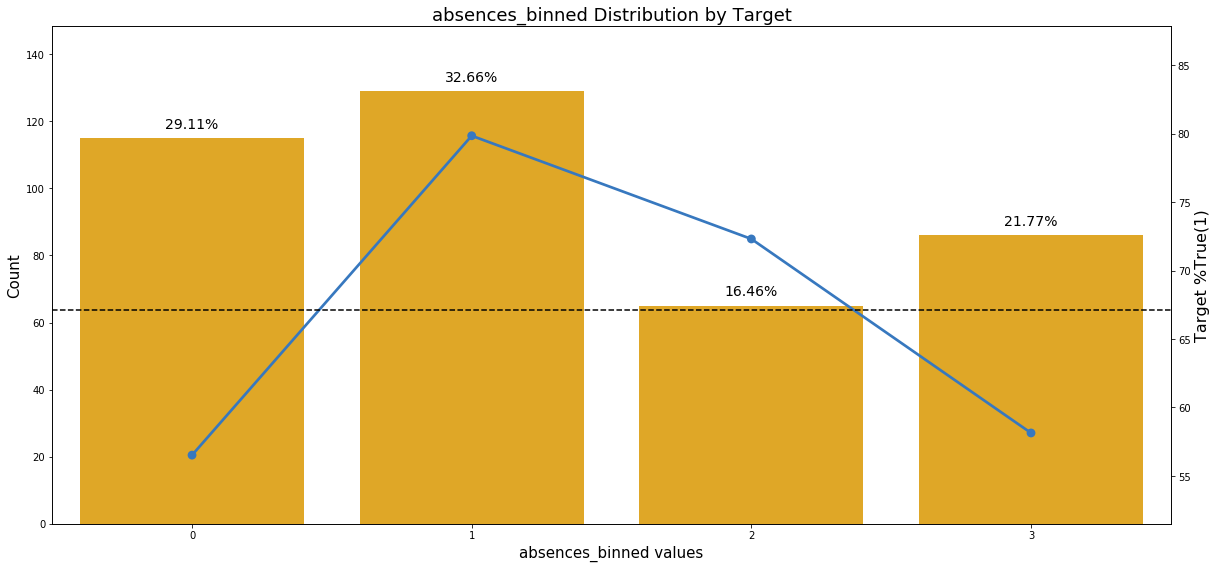

In [252]:
f.ploting_cat_fet(data, ['absences_binned'], vis_row=1, vis_col=1)